## Most parts of this notebook are **identical** to:
    - scripts/evaluate_change_it_3d.py
    - evaluation/all_metrics.py

In [51]:
import torch
import numpy as np
import os.path as osp
from functools import partial

from changeit3d.in_out.changeit3d_net import prepare_input_data
from changeit3d.in_out.language_contrastive_dataset import LanguageContrastiveDataset
from changeit3d.in_out.pointcloud import pc_loader_from_npz, uniform_subsample
from changeit3d.in_out.basics import pickle_data
from changeit3d.in_out.basics import create_logger
from changeit3d.in_out.arguments import parse_evaluate_changeit3d_arguments

from changeit3d.utils.basics import parallel_apply
from changeit3d.models.model_descriptions import load_pretrained_changeit3d_net
from changeit3d.models.model_descriptions import load_pretrained_pc_ae

from changeit3d.evaluation.auxiliary import pc_ae_transform_point_clouds, sgf_transform_point_clouds
from changeit3d.external_tools.sgf.loader import initialize_and_load_sgf
from changeit3d.utils.visualization import visualize_point_clouds_3d_v2, plot_3d_point_cloud


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
##
## Manually specify the underlying files using our pretrained nets or yours
##

shape_generator_type = "pcae"

top_data_dir = '../../data'
# shape_talk_file = f'{top_data_dir}/shapetalk/language/shapetalk_preprocessed_public_version_0.csv'
shape_talk_file = '/home/kcmacauley/changeit3d/changeit3d/data/seg_shapetalk/shapetalk_preprocessed_filtered_for_shape_removal.csv'
vocab_file = f'{top_data_dir}/shapetalk/language/vocabulary.pkl'
top_pc_dir = f'{top_data_dir}/shapetalk/point_clouds/scaled_to_align_rendering'
pretrained_oracle_listener = f'{top_data_dir}/pretrained/listeners/oracle_listener/all_shapetalk_classes/rs_2023/listener_dgcnn_based/ablation1/best_model.pkl'
pretrained_shape_classifier =  f'{top_data_dir}/pretrained/pc_classifiers/rs_2022/all_shapetalk_classes/best_model.pkl'
shape_part_classifiers_top_dir = f'{top_data_dir}/pretrained/part_predictors/shapenet_core_based'
latent_codes_file = '/home/kcmacauley/changeit3d/changeit3d/scripts/logs_pc_ae/04-20-2024-12-44-11/latent_codes.pkl'


### PC-AE based:    
if shape_generator_type == "pcae":    
    pretrained_shape_generator = f'{top_data_dir}/pretrained/pc_autoencoders/pointnet/rs_2022/points_4096/all_classes/scaled_to_align_rendering/08-07-2022-22-23-42/best_model.pt'
    ## selected PC-AE ablation:         
    selected_ablation = 'decoupling_mag_direction/idpen_0.05_sc_True/' # decoupled and with self-contrast=True
    
### SGF-AE based:        
if shape_generator_type == "sgf":    
    selected_ablation = 'decoupling_mag_direction/idpen_0.05_sc_True/'        
    sub_sample_dataset = '100' # just evaluate over 100 randomly selected test shapes

pretrained_changeit3d = f'{top_data_dir}/pretrained/changers/{shape_generator_type}_based/all_shapetalk_classes/{selected_ablation}/best_model.pt'

In [53]:
notebook_arguments = []

notebook_arguments.extend(['-shape_talk_file', shape_talk_file])
notebook_arguments.extend(['-latent_codes_file', latent_codes_file])
notebook_arguments.extend(['-vocab_file', vocab_file])
notebook_arguments.extend(['-pretrained_changeit3d', pretrained_changeit3d])
notebook_arguments.extend(['-top_pc_dir', top_pc_dir])
notebook_arguments.extend(['--shape_generator_type', shape_generator_type])
notebook_arguments.extend(['--pretrained_oracle_listener', pretrained_oracle_listener])
notebook_arguments.extend(['--pretrained_shape_classifier', pretrained_shape_classifier])
notebook_arguments.extend(['--shape_part_classifiers_top_dir', shape_part_classifiers_top_dir])

if 'pretrained_shape_generator' in  locals():
    notebook_arguments.extend(['--pretrained_shape_generator', pretrained_shape_generator])

if 'sub_sample_dataset' in  locals():
    notebook_arguments.extend(['--sub_sample_dataset', sub_sample_dataset])    
    

args = parse_evaluate_changeit3d_arguments(notebook_arguments)
logger = create_logger(args.log_dir)



Input arguments:


{'batch_size': 1024,
 'clean_train_val_data': False,
 'compute_fpd': True,
 'evaluate_retrieval_version': False,
 'experiment_tag': None,
 'gpu_id': 0,
 'latent_codes_file': '/home/kcmacauley/changeit3d/changeit3d/scripts/logs_pc_ae/04-20-2024-12-44-11/latent_codes.pkl',
 'log_dir': './logs',
 'n_sample_points': 2048,
 'num_workers': 10,
 'pretrained_changeit3d': '../../data/pretrained/changers/pcae_based/all_shapetalk_classes/decoupling_mag_direction/idpen_0.05_sc_True//best_model.pt',
 'pretrained_oracle_listener': '../../data/pretrained/listeners/oracle_listener/all_shapetalk_classes/rs_2023/listener_dgcnn_based/ablation1/best_model.pkl',
 'pretrained_shape_classifier': '../../data/pretrained/pc_classifiers/rs_2022/all_shapetalk_classes/best_model.pkl',
 'pretrained_shape_generator': '../../data/pretrained/pc_autoencoders/pointnet/rs_2022/points_4096/all_classes/scaled_to_align_rendering/08-07-2022-22-23-42/best_model.pt',
 'random_seed': 2022,
 'restrict_shape_

In [54]:
##
# Prepare the input data
##
df, shape_to_latent_code, shape_latent_dim, vocab = prepare_input_data(args, logger)

##
# Prepare the data loaders
##
def to_stimulus_func(x):
    return shape_to_latent_code[x]

split = 'test'
ndf = df[df.changeit_split == split].copy()
ndf.reset_index(inplace=True, drop=True)

if args.sub_sample_dataset is not None:
    np.random.seed(args.random_seed)
    ndf = ndf.sample(args.sub_sample_dataset)
    ndf.reset_index(inplace=True, drop=True)
    
dataset = LanguageContrastiveDataset(ndf,
                                     to_stimulus_func,
                                     n_distractors=1,
                                     shuffle_items=False)  # important, source (distractor) now is first

dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         worker_init_fn=lambda _ : np.random.seed(args.random_seed)) 

Latent codes with dimension 256 are loaded.
Latent codes with dimension 256 are loaded.
Latent codes with dimension 256 are loaded.
Latent codes with dimension 256 are loaded.
Latent codes with dimension 256 are loaded.


Restricting to class(es) ['chair', 'lamp']. Total utterances: 140
Restricting to class(es) ['chair', 'lamp']. Total utterances: 140
Restricting to class(es) ['chair', 'lamp']. Total utterances: 140
Restricting to class(es) ['chair', 'lamp']. Total utterances: 140
Restricting to class(es) ['chair', 'lamp']. Total utterances: 140


In [55]:
##
# Loading pretrained ChangetIt3DNet.   Please update the .config file to point to the directory YOU saved/downloaded this network.
##
logger.info('Loading pretrained ChangetIt3DNet (C3DNet)')
c3d_net, best_epoch, c3d_args = load_pretrained_changeit3d_net(args.pretrained_changeit3d, shape_latent_dim, vocab)
device = torch.device("cuda:" + str(args.gpu_id))
c3d_net = c3d_net.to(device)
logger.info(f'The model is variant `{c3d_args.shape_editor_variant}` trained with {c3d_args.identity_penalty} identity penalty and Self-Contrast={c3d_args.self_contrast}.')
logger.info(f'Loaded at epoch {best_epoch}.')


Loading pretrained ChangetIt3DNet (C3DNet)
Loading pretrained ChangetIt3DNet (C3DNet)
Loading pretrained ChangetIt3DNet (C3DNet)
Loading pretrained ChangetIt3DNet (C3DNet)
Loading pretrained ChangetIt3DNet (C3DNet)


Doing ST ablation decoupling_mag_direction with self contrast True
The model is variant `decoupling_mag_direction` trained with 0.05 identity penalty and Self-Contrast=True.
The model is variant `decoupling_mag_direction` trained with 0.05 identity penalty and Self-Contrast=True.
The model is variant `decoupling_mag_direction` trained with 0.05 identity penalty and Self-Contrast=True.
The model is variant `decoupling_mag_direction` trained with 0.05 identity penalty and Self-Contrast=True.
The model is variant `decoupling_mag_direction` trained with 0.05 identity penalty and Self-Contrast=True.
Loaded at epoch 77.
Loaded at epoch 77.
Loaded at epoch 77.
Loaded at epoch 77.
Loaded at epoch 77.


In [56]:
##
# Loading pretrained Shape Generator (AutoEncoder).
##
if args.shape_generator_type == 'pcae':
    pc_ae, pc_ae_args = load_pretrained_pc_ae(args.pretrained_shape_generator)
    pc_ae = pc_ae.to(device)
    pc_ae = pc_ae.eval()
elif args.shape_generator_type == 'sgf':    
    sgf_ae = initialize_and_load_sgf()
    sgf_trainer = sgf_ae.trainer
    sgf_trainer.cfg.inference.num_points = args.n_sample_points
else:
    assert False

Pretrained PC-AE is loaded at epoch 186.


In [57]:
check_loader = dataloader
gt_classes = check_loader.dataset.df.source_object_class

# Decode edits
if args.shape_generator_type == 'pcae':
    transformation_results = pc_ae_transform_point_clouds(pc_ae,
                                                          c3d_net,
                                                          check_loader,
                                                          stimulus_index=0,
                                                          scales=[0],  # use "0" to get also the simple reconstruction of the decoder (no edit)
                                                          device=device)
        
elif args.shape_generator_type == 'sgf':        
    transformation_results = sgf_transform_point_clouds(sgf_trainer, 
                                                        c3d_net,
                                                        check_loader,
                                                        stimulus_index=0,                                                            
                                                        scales=[1],     
                                                        n_points_per_shape=args.n_sample_points, 
                                                        batch_size=128, 
                                                        max_recon_batches=None)    

In [58]:
transformed_shapes = transformation_results['recons'][0]
language_used = [vocab.decode_print(s) for s in transformation_results['tokens']]
gt_pc_files = check_loader.dataset.df.source_uid.apply(lambda x: osp.join(args.top_pc_dir, x + ".npz")).tolist()

if args.save_reconstructions:
    outputs = dict()
    outputs['transformed_shapes'] = transformed_shapes
    outputs['language_used'] = language_used
    outputs['gt_input_pc_files'] = gt_pc_files
    pickle_data(osp.join(args.log_dir, 'evaluation_outputs.pkl'), outputs)

140


In [59]:
## Sample point-clouds to desired granularity for evaluation
if transformed_shapes.shape[-2] != args.n_sample_points:
    transformed_shapes = np.array([uniform_subsample(s, args.n_sample_points, args.random_seed)[0] for s in transformed_shapes])
    
## Load ground-truth input point-clouds
pc_loader =  partial(pc_loader_from_npz, n_samples=args.n_sample_points, random_seed=args.random_seed)
gt_pcs = parallel_apply(gt_pc_files, pc_loader, n_processes=20) # or, gt_pcs = [pc_loader(m) for m in gt_pc_files]
gt_pcs = np.array(gt_pcs)

sentences = ndf.utterance_spelled.values
gt_classes = gt_classes.values

[[[-0.16016597 -0.18046226  0.1663124 ]
  [-0.11591232 -0.17001508  0.06653922]
  [ 0.15273826  0.00140414  0.1691287 ]
  ...
  [-0.09200937 -0.0520026   0.13484712]
  [ 0.14915594 -0.02125014  0.17178448]
  [-0.15643245 -0.04741832  0.16985115]]

 [[-0.15915105 -0.05623969  0.14320886]
  [-0.08376726 -0.07265939  0.03263776]
  [ 0.16013311 -0.01814391  0.16113682]
  ...
  [-0.07940731 -0.01953611  0.14679424]
  [ 0.15967864 -0.02281914  0.16001332]
  [-0.16154623 -0.0360139   0.16001138]]

 [[-0.17747083 -0.02736646  0.1407488 ]
  [-0.11280626 -0.00418865  0.02455139]
  [ 0.17549486  0.05112593  0.15323485]
  ...
  [-0.10045289 -0.0242391   0.13228846]
  [ 0.17869398  0.05176105  0.1516354 ]
  [-0.1783875   0.00246392  0.1454471 ]]

 ...

 [[-0.09084519 -0.2515821   0.10940583]
  [-0.07759477 -0.20913972  0.00728584]
  [-0.02944035  0.0522103  -0.00282374]
  ...
  [-0.02458003  0.23245749  0.00557921]
  [-0.02762638  0.03697617 -0.00026335]
  [-0.02053181  0.05504236  0.00138699]]

 [

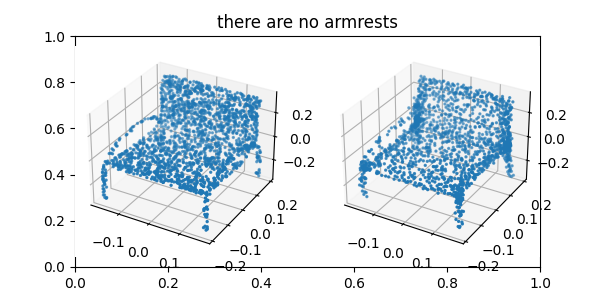

In [65]:
ridx = np.random.randint(len(transformed_shapes))
vis_axis_order = [0, 2, 1]
visualize_point_clouds_3d_v2([gt_pcs[ridx], transformed_shapes[ridx]], fig_title=language_used[ridx])

In [66]:
results_on_metrics = dict()

Instead of running directly `run_all_metrics(transformed_shapes, gt_pcs, gt_classes, sentences, vocab, args, logger)`

Let's open-it-up.

In [67]:
import torch
import numpy as np
import pandas as pd
import os.path as osp
from torch.utils.data import DataLoader
from collections import OrderedDict
from functools import partial

from changeit3d.in_out.pointcloud import (PointcloudDataset, 
                                          swap_axes_of_pointcloud,
                                          center_in_unit_sphere)
from changeit3d.evaluation.generic_metrics import (chamfer_dists,
                                                   chamfer_dists_on_masked_pointclouds,
                                                   difference_in_probability,
                                                   get_clf_probabilities)
from changeit3d.evaluation.listening_based import listening_fit_on_raw_pcs
from changeit3d.evaluation.semantic_part_based import mark_part_reference_in_sentences, masks_of_referred_parts_for_pcs
from changeit3d.evaluation.fpd import calculate_fpd
from changeit3d.models.shape_part_segmentors import shape_net_parts_segmentor_inference, load_shape_net_parts_segmentor


network_input_transformations = dict()

## this is the transformation we use in our pretrained pc-based-classifier
## YOU MUST Change this accordingly if you use a different classifier
network_input_transformations['shape_classifier'] = partial(center_in_unit_sphere, in_place=False)

def pc_transform_for_part_predictor(pc):
    pc = swap_axes_of_pointcloud(pc, [0, 2, 1])
    pc = center_in_unit_sphere(pc)
    return pc        

## this is the transformation we use in our pretrained part-predictor-classifier
## YOU MUST Change this accordingly if you use a different part-predictor
network_input_transformations['part_predictor'] = pc_transform_for_part_predictor

In [68]:
#Prepare input for evaluation
gt_classes = pd.Series(gt_classes, name='shape_class')  #convert to pandas for ease of use via .groupby    
tokens = pd.Series([sent.split() for sent in sentences])
max_len = tokens.apply(len).max()
tokens_encoded = np.stack(tokens.apply(lambda x: vocab.encode(x, max_len=max_len))) # encode to ints and put them in a N-shape array

In [73]:
#############################################
# Test-1: Holistic (regular) Chamfer distance
#############################################
scale_chamfer_by = 1000
batch_size_for_cd = 2048

for cmp_with in [gt_pcs]:
    holistic_cd_mu, holistic_cds = chamfer_dists(cmp_with, transformed_shapes,
                                                bsize=min(len(transformed_shapes), batch_size_for_cd), 
                                                device=device)
    torch.cuda.empty_cache()
    score = round(holistic_cd_mu * scale_chamfer_by, 3)
    score_per_class = (pd.concat([gt_classes, pd.DataFrame(holistic_cds.tolist())], axis=1).groupby('shape_class').mean()*scale_chamfer_by).round(3)
    score_per_class = score_per_class.reset_index().rename(columns={0: 'holistic-chamfer'})
    
    logger.info(f"Chamfer Distance (all pairs), Average: {score}")    
    logger.info(f"Chamfer Distance (all pairs), Average, per class:")
    logger.info(score_per_class)
    
    results_on_metrics['Chamfer_all_pairs_average'] = score
    results_on_metrics['Chmafer_all_pairs_per_class'] = score_per_class

1
Chamfer Distance (all pairs), Average: 0.261
Chamfer Distance (all pairs), Average: 0.261
Chamfer Distance (all pairs), Average: 0.261
Chamfer Distance (all pairs), Average: 0.261
Chamfer Distance (all pairs), Average: 0.261
Chamfer Distance (all pairs), Average, per class:
Chamfer Distance (all pairs), Average, per class:
Chamfer Distance (all pairs), Average, per class:
Chamfer Distance (all pairs), Average, per class:
Chamfer Distance (all pairs), Average, per class:
  shape_class  holistic-chamfer
0       chair             0.252
1        lamp             0.305
  shape_class  holistic-chamfer
0       chair             0.252
1        lamp             0.305


  shape_class  holistic-chamfer
0       chair             0.252
1        lamp             0.305
  shape_class  holistic-chamfer
0       chair             0.252
1        lamp             0.305
  shape_class  holistic-chamfer
0       chair             0.252
1        lamp             0.305


In [35]:
#############################################
# Test-2: LAB
#############################################    
# Loading (optionally) a separately trained ORACLE neural listener, to be used for LAB measurements.
oracle_listener = None
if args.pretrained_oracle_listener:
    oracle_listener = torch.load(args.pretrained_oracle_listener).eval().to(device)
    _, all_boosts, avg_wins, avg_boost = listening_fit_on_raw_pcs(gt_pcs, transformed_shapes, tokens_encoded, oracle_listener, device=device)
    
    torch.cuda.empty_cache()
    logger.info(f"LAB Average:{avg_boost}")
    logger.info(f"LAB-related-metric: Times edit is favored by listener against the original input, Average:{avg_wins}")
    results_on_metrics['LAB_avg'] = avg_boost
    results_on_metrics['LAB_wins'] = avg_wins

    score_per_class = (pd.concat([gt_classes, pd.DataFrame(all_boosts.tolist())], axis=1).groupby('shape_class').mean())
    score_per_class = score_per_class.reset_index().rename(columns={0:'LAB'})
    logger.info(f"LAB (all pairs), Average, per class:")
    logger.info(score_per_class)

    results_on_metrics['LAB_per_class'] = score_per_class

LAB Average:0.6268475651741028
LAB-related-metric: Times edit is favored by listener against the original input, Average:0.92
LAB (all pairs), Average, per class:
  shape_class       LAB
0       chair  0.624839
1        lamp  0.475342
2       table  0.725727


the seat is a smooth rectangular shape


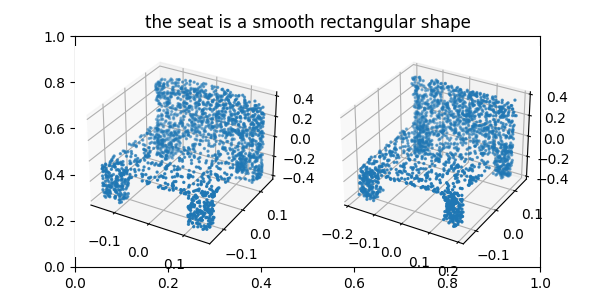

In [41]:
### Visualize a sample of case where the oracle considers the transformation *LESS* compatible than the input.
ridx = np.random.choice(np.arange(len(all_boosts))[all_boosts<0])
print(language_used[ridx])
visualize_point_clouds_3d_v2([gt_pcs[ridx], transformed_shapes[ridx]], fig_title=language_used[ridx])

In [53]:
#############################################
# Test-6: Part-Based (Localized) Metrics
#############################################              

if args.shape_part_classifiers_top_dir:    
    lgd_scores = dict()
    lgd_stats = dict()
    lgd_scores['without_parts_per_class'] = dict()
    lgd_scores['GD_on_pairs_with_parts_per_class'] = dict()
    lgd_scores['with_parts_per_class'] = dict()
    lgd_scores['with_parts_normalized_per_class'] = dict()
                                
    for shape_class in ['chair']:
        # Loading a part-clf to measure the localized-Geometric-Difference (l-GD) score
        file_location = osp.join(args.shape_part_classifiers_top_dir, f'best_seg_model_{shape_class}.pth')
        evaluating_part_predictor = load_shape_net_parts_segmentor(file_location, shape_class)
        evaluating_part_predictor = evaluating_part_predictor.to(device)
            
        idx_per_class = (gt_classes[gt_classes == shape_class].index).tolist()
        input_gt = gt_pcs[idx_per_class]
        input_trans = transformed_shapes[idx_per_class]
        
        gt_loader = DataLoader(PointcloudDataset(input_gt, pc_transform=network_input_transformations['part_predictor']), batch_size=128, num_workers=10)        
        trans_loader = DataLoader(PointcloudDataset(input_trans, pc_transform=network_input_transformations['part_predictor']), batch_size=128, num_workers=10)
        
        # STEP-1 predict the parts of -all- shapes coupled with lang
        pred_parts_gt = shape_net_parts_segmentor_inference(evaluating_part_predictor, gt_loader, device=device)
        pred_parts_trans = shape_net_parts_segmentor_inference(evaluating_part_predictor, trans_loader, device=device)        
        
        ## Collect data about the predicted/referred part before computing LGD

        # STEP-2 find the actual references that do part-specific language to focus            
        _, ref_parts_idx = mark_part_reference_in_sentences(tokens[idx_per_class], gt_classes[idx_per_class])
        rows_to_part_idx = OrderedDict()
        no_part_referred = []
        for i, v in enumerate(ref_parts_idx):
            if len(v) > 0:  # i.e., there is a part to be removed for this example
                rows_to_part_idx[i] = v
            else:
                no_part_referred.append(i)  # no part referred (so should be ignored from all localized-GD computations)

        # compute masks covering the points that belong to a referred part
        mask_gt = masks_of_referred_parts_for_pcs(input_gt, pred_parts_gt, rows_to_part_idx)
        mask_tr = masks_of_referred_parts_for_pcs(input_trans, pred_parts_trans, rows_to_part_idx)
        assert len(mask_gt) == len(mask_tr) & len(input_gt) == len(input_trans)
    
        # find shapes for which all points belong to the part(s), so the PC will be empty post its removal
        all_points_g = np.where((mask_gt == False).sum(1) == mask_gt.shape[1])[0]
        all_points_t = np.where((mask_tr == False).sum(1) == mask_tr.shape[1])[0]
        all_points = list(set(all_points_g).union(all_points_t))        
                
        # Also find cases where the part-predictor did not find any point belonging to the referred parts in BOTH or EITHER source/target
        referred_part_not_predicted_at_all = []
        referred_part_not_predicted_in_one_of_them = []
        for i, p in enumerate(ref_parts_idx):
            pred_has_it = set(p) <= set(np.unique(pred_parts_gt[i]))
            gt_has_it = set(p) <= set(np.unique(pred_parts_trans[i]))
            
            if not pred_has_it and not gt_has_it:
                referred_part_not_predicted_at_all.append(i)
            if not pred_has_it or not gt_has_it:                
                referred_part_not_predicted_in_one_of_them.append(i)
        
        ## OK - NOW:
        # 
        # A. - let's compute localized measurements where **we exclude** the referred part
        
        # for this we should ignore CD on the following:
        ignore_excluding = no_part_referred                    # obvious
        ignore_excluding += all_points                         # if all points are assigned to referred parts the entire shape will be reduced to the empty set
        ignore_excluding += referred_part_not_predicted_at_all # the predictor did not find the part(s) in both of them, so there is nothing to exclude        
        lgd_stats[f"{shape_class}_without_n_ignore"] = len(set(ignore_excluding))
        
        ## let's put 1's on the masks of the above shape pairs to not have chamfer distance computation crash (we will ignore these results anyway post computation)
        mask_gt_excluding = mask_gt.copy()
        mask_tr_excluding = mask_tr.copy()
        mask_gt_excluding[ignore_excluding] = np.ones_like(mask_gt_excluding[ignore_excluding])
        mask_tr_excluding[ignore_excluding] = np.ones_like(mask_tr_excluding[ignore_excluding])
                                
        # compute the cd on all points but the parts
        _, masked_cds = chamfer_dists_on_masked_pointclouds(input_gt, input_trans, mask_gt_excluding, mask_tr_excluding, bsize=2048, device=device)
        torch.cuda.empty_cache()
        masked_cd_mu = np.mean([mc for c, mc in enumerate(masked_cds) if c not in set(ignore_excluding)])
        score = round(masked_cd_mu * scale_chamfer_by, 3)
        
        lgd_scores['without_parts_per_class'][shape_class] = score
        logger.info(f'(l)-GD excluding part(s) ({shape_class}): {score}')
                
        # compute (again) the cd ignoring part masks altogether
        _, unmasked_cds = chamfer_dists(input_gt, input_trans, bsize=2048, device=device)
        score = np.mean([hc for c, hc in enumerate(unmasked_cds) if c not in set(ignore_excluding)])
        score = round(score * scale_chamfer_by, 3)
        logger.info(f'GD on entire shapes when both have predicted referred parts  ({shape_class}): {score}')                                                        

(l)-GD excluding part(s) (chair): 0.353
GD on entire shapes when both have predicted referred parts  (chair): 0.315


In [75]:
## See a bit deeper on LGD -- PARTS

## I.e., compare and visualize CD and LGD on given pairs marked with part-references

In [59]:
%matplotlib inline

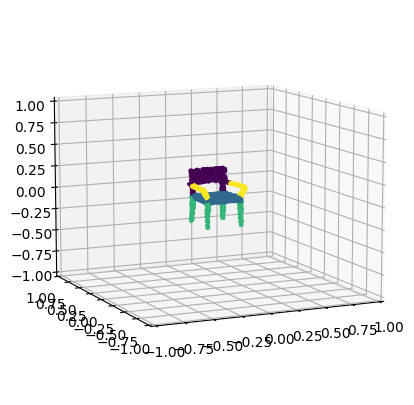

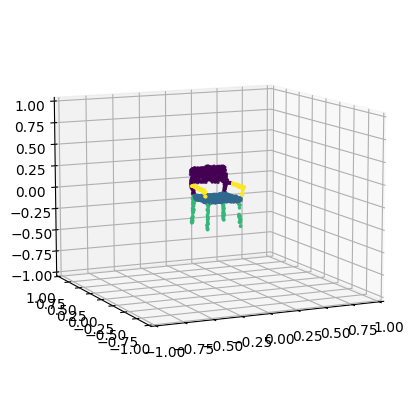

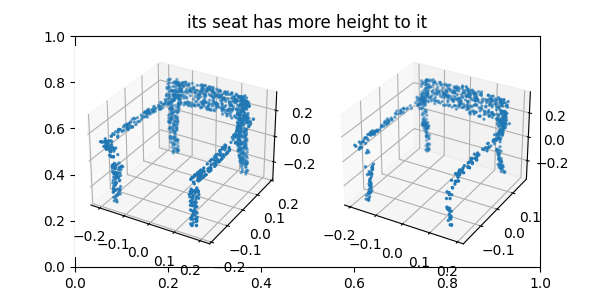

0.00019359515863470733 0.0002070249801920366


In [76]:
shapes_to_apply_lgd = np.setdiff1d(np.arange(len(input_gt)), ignore_excluding)
ridx = np.random.choice(shapes_to_apply_lgd)

plot_3d_point_cloud(input_gt[ridx], c=pred_parts_gt[ridx], visualization_pc_axis=[0,2,1]);
plot_3d_point_cloud(input_trans[ridx], c=pred_parts_trans[ridx], visualization_pc_axis=[0,2,1]);

display(visualize_point_clouds_3d_v2([input_gt[ridx][mask_gt_excluding[ridx]], 
                                      input_trans[ridx][mask_tr_excluding[ridx]]], 
                                     fig_title=np.array(language_used)[idx_per_class][ridx]))

print(float(unmasked_cds[ridx]), masked_cds[ridx])

In [77]:
# OBSERVE in the above image that despite having removing the seat when computing the LGD:
# The LDG is larger! than the naive chamfer? Why? 

### Well it is matter of the new density (number of points) the chamfer-based LGD is working with! 
## (see also explanation at top-level README of the changeit3d repo)

In [78]:
# Let's demonstrate more the above explanation!
## Recompute Naive Chamfer with the density (number of points) used by LGD: is it still a smaller distance? 

if True: 
    mask_gt_excluding_random = np.zeros_like(mask_gt_excluding)  # sub-sample at that lower density the pointclouds
    mask_tr_excluding_random = np.zeros_like(mask_tr_excluding)

    for i, row in enumerate(mask_gt_excluding):
        on_bits = row.sum()
        random_pos = np.random.choice(len(row), on_bits, replace=False)
        mask_gt_excluding_random[i][random_pos] = True

    for i, row in enumerate(mask_tr_excluding):
        on_bits = row.sum()
        random_pos = np.random.choice(len(row), on_bits, replace=False)
        mask_tr_excluding_random[i][random_pos] = True
    
_, masked_cds = chamfer_dists_on_masked_pointclouds(input_gt, input_trans, mask_gt_excluding_random, mask_tr_excluding_random, bsize=2048, device=device)
torch.cuda.empty_cache()
masked_cd_mu_random = np.mean([mc for c, mc in enumerate(masked_cds) if c not in set(ignore_excluding)])
score = round(masked_cd_mu_random * scale_chamfer_by, 3)


In [82]:
print(masked_cds[ridx]) # THIS IS BIGGER!

0.0002803435159284015
